In [1]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph
import numpy as np

In [2]:
from littlegrad2.engine import Tensor

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        #dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record') # original karpathy version, my version below
        #lerbel = "{{ data " + str(np.round(n.data, 2)) + " | grad " + str(np.round(n.grad, 2)) + " }}"

        lerbel = "{{"
        for row in np.atleast_2d(np.squeeze(n.grad)):
            lerbel += "{" + np.array2string(row, separator = '|', precision = 2, suppress_small = True) + "}|"
        lerbel = lerbel[:-1] + "}}"
        dot.node(name=str(id(n)), label = lerbel, shape = 'record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

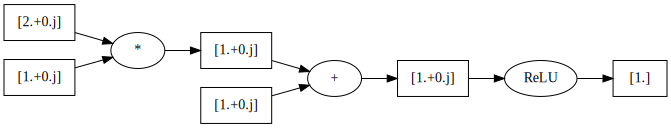

In [4]:
# a very simple example
x = Tensor(1.0)
y = (x * 2 + 1).relu()
y.backprop()
draw_dot(y)

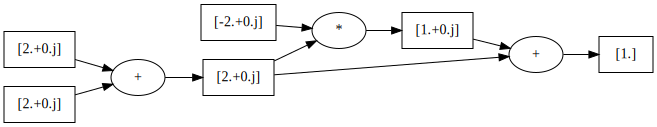

In [5]:
#my own test for incest cases (child and parent making child nodes)
a = Tensor(-4.0)
b = Tensor(2.0)
c = a + b
c += c * 1

c.backprop()
draw_dot(c)

NEW TOPO SORT (worked cuz it can detect and avoid incest cases):
        nodeList = []
        visitedNodes = set()

        def getNodes(val):
            if val not in visitedNodes:
                for child in val.children:
                    getNodes(child)
                nodeList.append(val)
                visitedNodes.add(val)
        getNodes(self)
        visitedNodes.reverse()

OLD TOPO SORT (didn't work, couldn't identify or avoid incest cases):
        childList = []
        def getChildren(val):
            if val not in childList:
                childList.append(val)
                for child in val.children:
                    getChildren(child)
        getChildren(self)

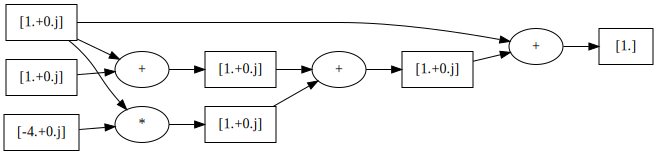

In [6]:
#my own test for correct neg() bookeeping
a = Tensor(-4.0)
b = Tensor(2.0)
c = a
c += 1 + c + (-a)
c.backprop()
draw_dot(c)

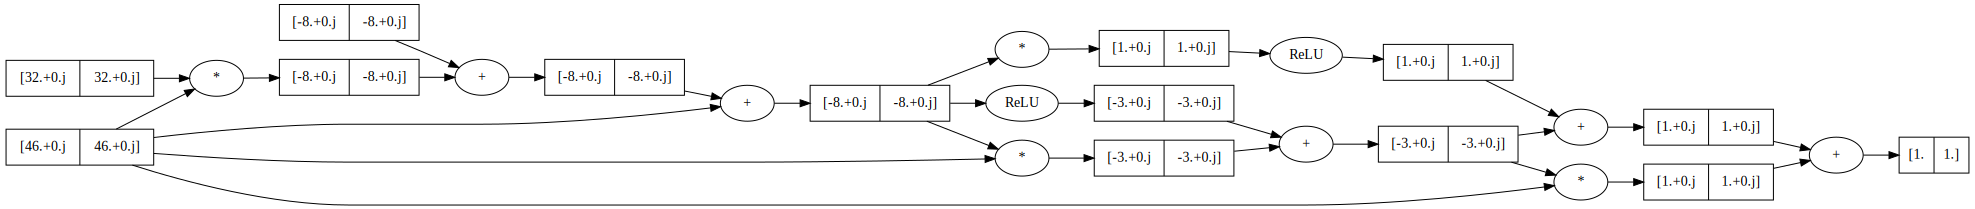

In [7]:
x = Tensor([-4.0, -4.0])
z = 2 * x + 2 + x
q = z.relu() + z * x
h = (z * z).relu()
y = h + q + q * x
y.backprop()
draw_dot(y)

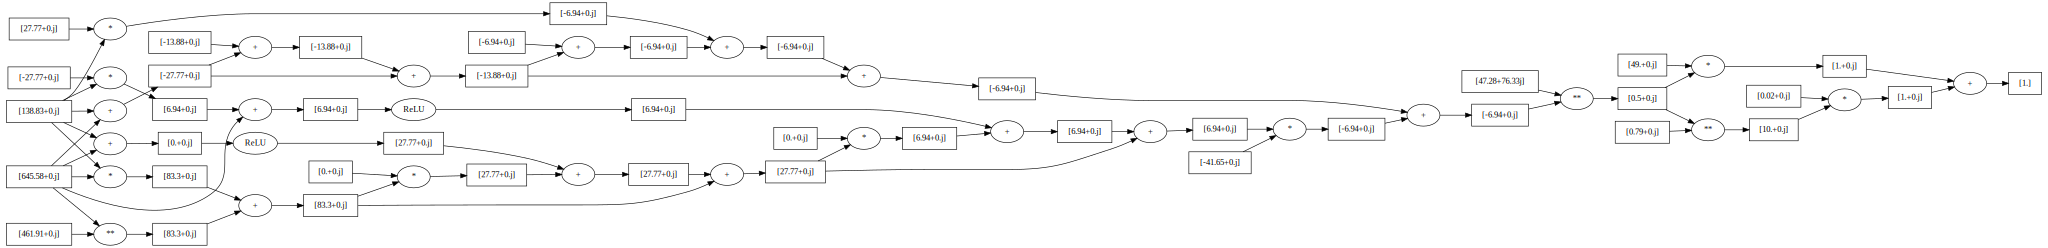

In [8]:
a = Tensor(-4.0)
b = Tensor(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
g.backprop()
draw_dot(g)

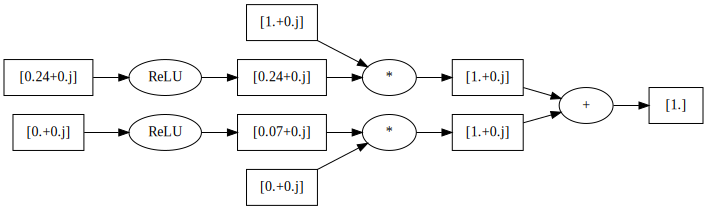

In [9]:
# a simple 2D neuron
import random
random.seed(1337)
#n = nn.Neuron(2)
#x = [Tensor(1.0), Tensor(-2.0)]
#y = n(x)
#y.backprop()

n = np.array([Tensor(random.uniform(-1, 1)), Tensor(random.uniform(-1, 1))])
x = [Tensor(1.0), Tensor(-2.0)]
y = n.dot([t.relu() for t in x])
y.backprop()

dot = draw_dot(y)
dot

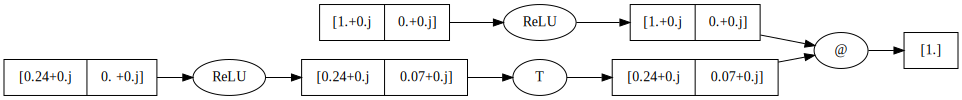

In [10]:
random.seed(1337)
n = Tensor([random.uniform(-1, 1), random.uniform(-1, 1)])
x = Tensor([1, -2])
y = n.relu() @ (x.relu().transpose())
y.backprop()

dot = draw_dot(y)
dot

In [11]:
a = Tensor(np.array([[[10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 0]]]))

b = Tensor(np.array([[[[1, 0, -1],
                     [1, 0, -1],
                     [1, 0, -1]]],
                     [[[-1, 0, 1],
                     [-1, 0, 1],
                     [-1, 0, 1]]]]))

print('a: ', a.data.shape, '\n', a.data.real)
print('b: ', b.data.shape, '\n', b.data.real)

def pad(self:Tensor):
    out = Tensor(data = self.data, children = (self,), op = 'S')

    def backward():
        self.grad += out.grad
    out.backward = backward
    return out

(nc, nx, ny) = a.data.shape
(fn, fc, fx, fy) = b.data.shape
for f in range(fn):
    #bPadded = Tensor(data = np.zeros_like(a.data)).sliceAdd(b.slice((f)).flip(), (slice(fc), slice(fx), slice(fy)))
    #print('a.dftNd(): ', a.dftNd().data.shape, '\n', np.round(a.dftNd().data, 2))
    #print('b.dftNd(): ', bPadded.dftNd().data.shape, '\n', np.round(bPadded.dftNd().data, 2))
    #print('a.dftNd()*b.dftNd(): ', (a.dftNd()*bPadded.dftNd()).data.shape, '\n', np.round((a.dftNd()*bPadded.dftNd()).data, 2))
    poop = (a.dftNd()*bPadded.dftNd()).idftNd()
    print('a.conv(b): ', poop.data.shape, '\n', np.round(poop.data, 2))

# y = a.reshape((nc, nx, ny)).conv(b).relu().avgPool().flatten()
# print('y: ', y.data.shape, '\n', np.round(y.data.real))
# y.backprop()

# dot = draw_dot(y)
# dot

a:  (1, 6, 6) 
 [[[10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]
  [10. 10. 10.  0.  0.  0.]]]
b:  (2, 1, 3, 3) 
 [[[[ 1.  0. -1.]
   [ 1.  0. -1.]
   [ 1.  0. -1.]]]


 [[[-1.  0.  1.]
   [-1.  0.  1.]
   [-1.  0.  1.]]]]
a.conv(b):  (1, 6, 6) 
 [[[-30.-0.j -30.-0.j  -0.-0.j  30.-0.j  30.-0.j  -0.-0.j]
  [-30.-0.j -30.-0.j  -0.-0.j  30.-0.j  30.-0.j  -0.-0.j]
  [-30.+0.j -30.+0.j   0.-0.j  30.-0.j  30.-0.j  -0.-0.j]
  [-30.-0.j -30.-0.j  -0.-0.j  30.-0.j  30.-0.j  -0.-0.j]
  [-30.-0.j -30.-0.j   0.-0.j  30.-0.j  30.-0.j  -0.-0.j]
  [-30.-0.j -30.-0.j  -0.-0.j  30.+0.j  30.-0.j  -0.-0.j]]]
a.conv(b):  (1, 6, 6) 
 [[[ 30.+0.j  30.+0.j   0.+0.j -30.+0.j -30.+0.j   0.+0.j]
  [ 30.+0.j  30.+0.j   0.+0.j -30.+0.j -30.+0.j   0.+0.j]
  [ 30.-0.j  30.-0.j  -0.+0.j -30.+0.j -30.+0.j   0.+0.j]
  [ 30.+0.j  30.+0.j   0.+0.j -30.+0.j -30.+0.j   0.+0.j]
  [ 30.+0.j  30.+0.j  -0.+0.j -30.+0.j -30.+0.j   0.+0.j

In [89]:
# a = Tensor(np.array([[[10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0],
#                      [10, 10, 10, 0, 0, 0]]]))
a = Tensor(np.array([[[10, 10, 10, 0, 0, 0],
                     [10, 20, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 20],
                     [10, 10, 10, 0, 0, 0],
                     [10, 10, 10, 0, 0, 20],
                     [20, 10, 10, 0, 0, 0]]]))
b = Tensor(np.arange(4).reshape((1, 2, 2)))
print(np.array(a.data.shape), np.array(b.data.shape))
dimLen = len(a.data.shape)
bPadded = np.pad(b.data, np.split(np.insert(np.array(a.data.shape) - np.array(b.data.shape), slice(0, dimLen, 1), 0), dimLen))
print(bPadded)

stride = 2
aSplit = [np.split(aPiece, np.ceil(a.data.shape[-1] / stride), axis = -1) for aPiece in np.split(a.data, np.ceil(a.data.shape[-2] / stride), axis = -2)]
for row in aSplit:
    for i in range(len(row)):
        row[i] = row[i].flatten()[np.argmax(row[i])] # item.flatten().slice(np.argmax(item))
print(a.data)
aSplit = np.array(aSplit)
print(aSplit.shape)

# NOTE: WRITE PAD, SPLIT, AND CONCATENATE FUNCTIONS, AND CONCATENATE CONV FILTERS TO AN APPENDED LIST INSTEAD OF TO OUT TENSOR

[1 6 6] [1 2 2]
[[[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [2.+0.j 3.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]]
[[[10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [10.+0.j 20.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j 20.+0.j]
  [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [10.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j 20.+0.j]
  [20.+0.j 10.+0.j 10.+0.j  0.+0.j  0.+0.j  0.+0.j]]]
(3, 3)


In [12]:
dot.render('gout')

'gout.svg'